In [ ]:
pip install gym numpy tensorflow keras


In [ ]:
import numpy as np
import gym
from gym import spaces

class SimpleChessEnv(gym.Env):
    def __init__(self):
        super(SimpleChessEnv, self).__init__()
        self.action_space = spaces.Discrete(64)  # 64 squares on the chess board
        self.observation_space = spaces.Box(low=0, high=1, shape=(8, 8, 1), dtype=np.float32)
        self.board = np.zeros((8, 8))
        self.done = False

    def reset(self):
        self.board = np.zeros((8, 8))
        self.done = False
        return self.board

    def step(self, action):
        row, col = divmod(action, 8)
        if self.board[row, col] == 0:
            self.board[row, col] = 1  # A simple rule: place a piece
            reward = 1
        else:
            reward = -1
        if np.sum(self.board) == 64:
            self.done = True
        return self.board, reward, self.done, {}

    def render(self, mode='human'):
        print(self.board)

env = SimpleChessEnv()


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Input
from tensorflow.keras.optimizers import Adam

class SimpleAgent:
    def __init__(self, state_shape, action_space):
        self.model = self.build_model(state_shape, action_space)
        self.model.compile(loss='mse', optimizer=Adam(learning_rate=0.001))

    def build_model(self, state_shape, action_space):
        model = Sequential()
        model.add(Input(shape=state_shape))  # Define explícitamente la capa de entrada
        model.add(Flatten())
        model.add(Dense(24, activation='relu'))
        model.add(Dense(24, activation='relu'))
        model.add(Dense(action_space, activation='linear'))
        return model

    def act(self, state):
        q_values = self.model.predict(state)
        return np.argmax(q_values[0])

    def train(self, state, target_f):
        self.model.fit(state, target_f, epochs=1, verbose=0)

agent = SimpleAgent(env.observation_space.shape, env.action_space.n)



In [ ]:
episodes = 1000
for e in range(episodes):
    state = env.reset()
    state = np.reshape(state, [1, 8, 8, 1])
    for time in range(64):
        action = agent.act(state)
        next_state, reward, done, _ = env.step(action)
        next_state = np.reshape(next_state, [1, 8, 8, 1])
        target = reward
        if not done:
            target += 0.95 * np.amax(agent.model.predict(next_state)[0])
        target_f = agent.model.predict(state)
        target_f[0][action] = target
        agent.train(state, target_f)
        state = next_state
        if done:
            print(f"Episode: {e+1}/{episodes}, Reward: {reward}")
            break


Streaming output truncated to the last 5000 lines.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step

In [ ]:
import chess
import numpy as np
import random
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, Input
from tensorflow.keras.optimizers import Adam

# Entorno de Ajedrez
class ChessEnv:
    def __init__(self):
        self.board = chess.Board()

    def reset(self):
        self.board.reset()
        return self.get_state()

    def get_state(self):
        return self.board.fen()

    def step(self, move):
        self.board.push(move)
        reward = 0
        done = False

        if self.board.is_checkmate():
            reward = 1
            done = True
        elif self.board.is_stalemate() or self.board.is_insufficient_material():
            done = True

        return self.get_state(), reward, done

    def render(self):
        print(self.board)

# MCTS Node
class MCTSNode:
    def __init__(self, state, parent=None, action=None):
        self.state = state
        self.parent = parent
        self.action = action
        self.children = []
        self.visits = 0
        self.value = 0.0

    def is_leaf(self):
        return len(self.children) == 0

    def select_child(self):
        # Seleccionar el nodo con la mejor relación valor/visitas
        return max(self.children, key=lambda child: child.value / (child.visits + 1) + np.sqrt(2 * np.log(self.visits + 1) / (child.visits + 1)))

    def expand(self, action, next_state):
        child_node = MCTSNode(next_state, parent=self, action=action)
        self.children.append(child_node)
        return child_node

    def update(self, reward):
        self.visits += 1
        self.value += reward

# Modelo de Red Neuronal
def build_model(input_shape):
    inputs = Input(shape=input_shape)
    x = Conv2D(128, kernel_size=3, activation='relu')(inputs)
    x = Conv2D(128, kernel_size=3, activation='relu')(x)
    x = Flatten()(x)

    # Head for policy
    policy = Dense(1968, activation='softmax')(x)  # 1968 es un número aproximado de posibles movimientos

    # Head for value
    value = Dense(1, activation='tanh')(x)

    model = Model(inputs=inputs, outputs=[policy, value])
    model.compile(optimizer=Adam(learning_rate=0.001), loss=['categorical_crossentropy', 'mean_squared_error'])
    return model

# Función para jugar y ver movimientos
def play_game(env, model, num_simulations):
    state = env.reset()
    mcts = MCTSNode(state)

    print("Inicio del juego:")
    env.render()
    print("--------------------")

    while not env.board.is_game_over():
        # Simular varios juegos desde el nodo actual
        for _ in range(num_simulations):
            node = mcts
            while not node.is_leaf():
                node = node.select_child()

            legal_moves = list(env.board.legal_moves)
            if not legal_moves:
                break

            action = random.choice(legal_moves)
            state, _, done = env.step(action)
            node = node.expand(action, state)
            reward = 0 if not done else 1
            node.update(reward)

        # Seleccionar el mejor movimiento
        best_child = max(mcts.children, key=lambda child: child.visits)
        action = best_child.action

        # Verifica si el movimiento es legal antes de aplicarlo
        if action in env.board.legal_moves:
            state, _, done = env.step(action)
            print(f"Movimiento: {env.board.san(action)}")
            env.render()
            print("--------------------")
        else:
            print(f"Movimiento ilegal detectado: {action}")
            break

        if done:
            break

    print("Fin del juego:")
    env.render()

# Configuración inicial
env = ChessEnv()
input_shape = (8, 8, 1)  # Simplificación del tablero
model = build_model(input_shape)

# Jugar un juego con simulaciones y ver movimientos
play_game(env, model, num_simulations=1000)


Inicio del juego:
r n b q k b n r
p p p p p p p p
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
P P P P P P P P
R N B Q K B N R
--------------------
Movimiento ilegal detectado: c2c4
Fin del juego:
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . K .
. . . . . . . .
. . . . . . . .
. . . . k . . .


In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import inspect

In [ ]:

%load_ext autoreload
%autoreload 2

In [ ]:
!pip install python-chess  # Python-Chess is the Python Chess Package that handles the chess environment
!pip install --upgrade git+https://github.com/arjangroen/RLC.git  # RLC is the Reinforcement Learning package

  Cloning https://github.com/arjangroen/RLC.git to /tmp/pip-req-build-nu3sq5ft
  Running command git clone --filter=blob:none --quiet https://github.com/arjangroen/RLC.git /tmp/pip-req-build-nu3sq5ft
  Resolved https://github.com/arjangroen/RLC.git to commit e54eb7380875f64fd06106c59aa376b426d9e5ca
  Preparing metadata (setup.py) ... done
  Created wheel for RLC: filename=RLC-0.3-py3-none-any.whl size=22553 sha256=ca56788a1fbe78ea3f63e299e618482bd16404fda73f8ccf6efe2d68902868e3
  Stored in directory: /tmp/pip-ephem-wheel-cache-2jhhxjba/wheels/85/f1/6e/1db6247793737c4a5458c09e55ff6481f387ae570ee00a5efe
Successfully built RLC


In [ ]:
import chess
from chess.pgn import Game
import RLC
from RLC.capture_chess.environment import Board
from RLC.capture_chess.learn import Q_learning
from RLC.capture_chess.agent import Agent

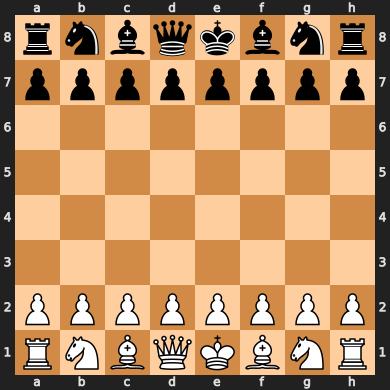

In [ ]:
board = Board()
board.board

In [ ]:
board.layer_board[0,::-1,:].astype(int)

array([[ 0,  0,  0,  0,  0,  0,  0,  0],
       [-1, -1, -1, -1, -1, -1, -1, -1],
       [ 0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0],
       [ 1,  1,  1,  1,  1,  1,  1,  1],
       [ 0,  0,  0,  0,  0,  0,  0,  0]])

https://www.kaggle.com/code/mandmdatascience/chess-engine-2-reinforcement-learning

In [31]:
!pip install chess


In [32]:
!pip install python-chess


In [33]:
import chess
board = chess.Board()
print(board.unicode())

♜ ♞ ♝ ♛ ♚ ♝ ♞ ♜
♟ ♟ ♟ ♟ ♟ ♟ ♟ ♟
⭘ ⭘ ⭘ ⭘ ⭘ ⭘ ⭘ ⭘
⭘ ⭘ ⭘ ⭘ ⭘ ⭘ ⭘ ⭘
⭘ ⭘ ⭘ ⭘ ⭘ ⭘ ⭘ ⭘
⭘ ⭘ ⭘ ⭘ ⭘ ⭘ ⭘ ⭘
♙ ♙ ♙ ♙ ♙ ♙ ♙ ♙
♖ ♘ ♗ ♕ ♔ ♗ ♘ ♖


In [34]:
def print_bitboard(bitboard):

    # for each row
    for i in range(8):

        # print bitboard of 1s/0s (we have to mirror the bitboard)
        if i == 0:
            print(format(bitboard, "064b")[8*(i+1)-1::-1])
        else:
            print(format(bitboard, "064b")[8*(i+1)-1:8*i-1:-1])

# bitboard of pawns
print_bitboard(board.pawns)

00000000
11111111
00000000
00000000
00000000
00000000
11111111
00000000


In [35]:
# bitboard of kings
print_bitboard(board.kings)

00001000
00000000
00000000
00000000
00000000
00000000
00000000
00001000


In [36]:
# bitboard of bishops
print_bitboard(board.bishops)

00100100
00000000
00000000
00000000
00000000
00000000
00000000
00100100


In [37]:
# bitboard of empty squares
print_bitboard(board.occupied ^ 2 ** 64 -1)

00000000
00000000
11111111
11111111
11111111
11111111
00000000
00000000


In [38]:
import numpy as np

def encode_valid_moves(board):

    valid_moves_dict = {}

    # for each valid move
    for move in board.legal_moves:

        # compute index based on starting square and target square
        index = 64 * (move.from_square) + (move.to_square)
        valid_moves_dict[index] = move

    return valid_moves_dict

valid_moves_dict = encode_valid_moves(board)
valid_moves_dict

{407: Move.from_uci('g1h3'),
 405: Move.from_uci('g1f3'),
 82: Move.from_uci('b1c3'),
 80: Move.from_uci('b1a3'),
 983: Move.from_uci('h2h3'),
 918: Move.from_uci('g2g3'),
 853: Move.from_uci('f2f3'),
 788: Move.from_uci('e2e3'),
 723: Move.from_uci('d2d3'),
 658: Move.from_uci('c2c3'),
 593: Move.from_uci('b2b3'),
 528: Move.from_uci('a2a3'),
 991: Move.from_uci('h2h4'),
 926: Move.from_uci('g2g4'),
 861: Move.from_uci('f2f4'),
 796: Move.from_uci('e2e4'),
 731: Move.from_uci('d2d4'),
 666: Move.from_uci('c2c4'),
 601: Move.from_uci('b2b4'),
 536: Move.from_uci('a2a4')}

In [39]:
def mask_and_valid_moves(board):

    mask = np.zeros((64, 64))
    valid_moves_dict = {}

    # for each valid move
    for move in board.legal_moves:

        # mask is a matrix
        mask[move.from_square, move.to_square] = 1

        # compute index based on starting square and target square
        index = 64 * (move.from_square) + (move.to_square)

        valid_moves_dict[index] = move

    return mask, valid_moves_dict

mask, valid_moves_dict = mask_and_valid_moves(board)
mask

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [40]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# This is our final mask layer
class MaskLayer(nn.Module):

    def __init__(self):
        super(MaskLayer, self).__init__()

    # mask is made of 0s/1s so it will just set to 0 any invalid move
    def forward(self, x, mask):
        return torch.mul(x, mask)

In [41]:
class DQN(nn.Module):

    def __init__(self):

        super(DQN, self).__init__()

        # input size = 8 (rows) x 8 (cols) x 16 (bitboards)
        # - 6 bitboards for white pieces
        # - 6 bitboards for black pieces
        # - 1 for empty squares
        # - 1 for castling rights
        # - 1 for en passant
        # - 1 for player

        # first convolutional layer 8x8x16 => 8x8x32
        self.conv1 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)

        # second convolutional layer 8x8x32 => 8x8x64
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)

        # third convolutional layer 8x8x64 => 8x8x128
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(128)

        # first fully connected layer 8192 => 8192
        self.fc1 = nn.Linear(128*64, 128*64)

        # second fully connected layer 8192 => 4096
        self.fc2 = nn.Linear(128*64, 64*64)

        # mask is made of 0s/1s so it will just set to 0 any invalid move 4096 => 4096
        self.mask = MaskLayer()

    def forward(self, x, mask=None, debug=False):

        # conv1 + bn1 with activation function ReLU
        x = nn.functional.relu(self.bn1(self.conv1(x)))

        # conv2 + bn2 with activation function ReLU
        x = nn.functional.relu(self.bn2(self.conv2(x)))

        # conv3 + bn3 with activation function ReLU
        x = nn.functional.relu(self.bn3(self.conv3(x)))

        # flatten will transform data structure from 3D 8x8x128 to 1D 8192
        x = nn.Flatten()(x)

        # fully connected with activation function ReLU
        x = nn.functional.relu(self.fc1(x))

        # fully connected WITHOUT ReLU (we want to keep negative values for our output layer)
        x = self.fc2(x)

        # if we have a mask we apply it to set to 0 all invalid moves
        if mask is not None:
            x = self.mask(x, mask)

        return x

In [42]:
!apt-get install -y stockfish


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
stockfish is already the newest version (14.1-1).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.


In [43]:
import chess
import chess.engine
import random

# Función para que el agente elija un movimiento aleatorio
def agent_choose_move(board):
    return random.choice(list(board.legal_moves))

# Crea un tablero de ajedrez
board = chess.Board()

# Crea una instancia del motor Stockfish
stockfish = chess.engine.SimpleEngine.popen_uci("/usr/games/stockfish")

# Analiza el tablero inicial con Stockfish
board_score_before = stockfish.analyse(board=board, limit=chess.engine.Limit(depth=5))\
    ['score'].relative.score(mate_score=10000)

# El agente elige un movimiento
move = agent_choose_move(board)
board.push(move)

# Realiza un movimiento aleatorio para las negras
board.push(random.choice(list(board.legal_moves)))

# Analiza el tablero final con Stockfish
board_score_after = stockfish.analyse(board=board, limit=chess.engine.Limit(depth=5))\
    ['score'].relative.score(mate_score=10000)

# Calcula la recompensa
reward = board_score_after/100 - board_score_before/100 - 0.01

print("Recompensa:", reward)


Recompensa: -0.30000000000000004


In [44]:
print(board.unicode())

♜ ♞ ♝ ♛ ♚ ♝ ♞ ♜
⭘ ♟ ♟ ♟ ♟ ♟ ♟ ♟
⭘ ⭘ ⭘ ⭘ ⭘ ⭘ ⭘ ⭘
♟ ⭘ ⭘ ⭘ ⭘ ⭘ ⭘ ⭘
⭘ ⭘ ⭘ ⭘ ⭘ ⭘ ⭘ ♙
⭘ ⭘ ⭘ ⭘ ⭘ ⭘ ⭘ ⭘
♙ ♙ ♙ ♙ ♙ ♙ ♙ ⭘
♖ ♘ ♗ ♕ ♔ ♗ ♘ ♖


In [45]:
move

Move.from_uci('h2h4')

In [46]:
reward

-0.30000000000000004

In [47]:
# Exploration rate
epsilon = 1
epsilon_decay = 0.995
epsilon_min = 0.01

# choose random with probability epsilon
if random.uniform(0, 1) <= epsilon:
    move = random.choice(list(board.legal_moves))

# choose best move with probability 1 - epsilon
else:
    move = agent_choose_move(board)

# reduce exploration rate after each step
epsilon = max(epsilon * epsilon_decay, epsilon_min)
epsilon

0.995

In [48]:
import os

class ChessAgent:

    # Constructor
    def __init__(self, input_model_path=None):

        # Exploration parameters
        self.epsilon = 1
        self.epsilon_decay = 0.99
        self.epsilon_min = 0.01

        # Training parameters
        self.gamma = 0.5 # tells the agent whether to prefer long term rewards or immediate rewards. 0 = greedy, 1 = long term
        self.learning_rate = 1e-03 # how fast the network updates its weights
        self.MEMORY_SIZE = 512 # how many steps/moves/samples to store. It is used for training (experience replay)
        self.MAX_PRIORITY = 1e+06 # max priority for a sample in memory. The higher the priority, the more likely the sample will be included in training
        self.memory = [] # memory data structure
        self.batch_size = 16 # how many sample to include in a training step

        self.policy_net = DQN()

        # Load trained model if exists
        if input_model_path is not None and os.path.exists(input_model_path):
            self.policy_net.load_state_dict(torch.load(input_model_path))

        # We use mean squared error as our loss function
        self.loss_function = nn.MSELoss()

        # Adam optimizer provides adaptive learning rate and a momentum-based approach that can help the neural network
        # learn faster and converge more quickly towards the optimal set of parameters that minimize the cost or loss function
        self.optimizer = torch.optim.Adam(self.policy_net.parameters(), lr=self.learning_rate)


    # Convert board into a 3D np.array of 16 bitboards
    def convert_state(self, board):

        # dictionary to store bitboards
        piece_bitboards = {}

        # for each color (white, black)
        for color in chess.COLORS:

            # for each piece type (pawn, bishop, knigh, rook, queen, kinb)
            for piece_type in chess.PIECE_TYPES:
                v = board.pieces_mask(piece_type, color)
                symbol = chess.piece_symbol(piece_type)
                i = symbol.upper() if color else symbol
                piece_bitboards[i] = v

        # empty bitboard
        piece_bitboards['-'] = board.occupied ^ 2 ** 64 - 1

        # player bitboard (full 1s if player is white, full 0s otherwise)
        player = 2 ** 64 - 1 if board.turn else 0

        # castling_rights bitboard
        castling_rights = board.castling_rights

        # en passant bitboard
        en_passant = 0
        ep = board.ep_square
        if ep is not None:
            en_passant |= (1 << ep)

        # bitboards (16) = 12 for pieces, 1 for empty squares, 1 for player, 1 for castling rights, 1 for en passant
        bitboards = [b for b in piece_bitboards.values()] + [player] + [castling_rights] + [en_passant]

        # for each bitboard transform integet into a matrix of 1s and 0s
        # reshape in 3D format (16 x 8 x 8)
        bitarray = np.array([
            np.array([(bitboard >> i & 1) for i in range(64)])
            for bitboard in bitboards
        ]).reshape((16, 8, 8))

        return bitarray


    # get the move index out of the 4096 possible moves, as explained before
    def get_move_index(self, move):
        index = 64 * (move.from_square) + (move.to_square)
        return index


    # returns mask of valid moves (out of 4096) + the dictionary with the valid moves and their indexes
    def mask_and_valid_moves(self, board):

        mask = np.zeros((64, 64))
        valid_moves_dict = {}

        for move in board.legal_moves:
            mask[move.from_square, move.to_square] = 1
            valid_moves_dict[self.get_move_index(move)] = move

        # mask is flatten and returned as a PyTorch tensor
        # a tensor is just a vector optimized for derivatives computation, used in PyTorch neural nets
        return torch.from_numpy(mask.flatten()), valid_moves_dict


    # insert a step/move/sample into memory to be used in training as experience replay
    def remember(self, priority, state, action, reward, next_state, done, valid_moves, next_valid_moves):

        # if memory is full, we delete the least priority element
        if len(self.memory) >= self.MEMORY_SIZE:

            min_value = self.MAX_PRIORITY
            min_index = 0

            for i,n in enumerate(self.memory):

                # priority is stored in the first position of the tuple
                if n[0] < min_value:
                    min_value = n[0]
                    min_index = i

            del self.memory[min_index]

        self.memory.append((priority, state, action, reward, next_state, done, valid_moves, next_valid_moves))


    # Take a board as input and return a valid move defined as tuple (start square, end square)
    def select_action(self, board, best_move):

        # convert board into the 16 bitboards
        bit_state = self.convert_state(board)

        # get valid moves
        valid_moves_tensor, valid_move_dict = self.mask_and_valid_moves(board)

        # with probability epsilon = Explore
        if random.uniform(0, 1) <= self.epsilon:

            r = random.uniform(0, 1)

            # inside exploration with probability 10% choose best move (as computed by stockfish)
            if r <= 0.1:
                chosen_move = best_move

            # with probability 90% choose a random move
            else:
                chosen_move = random.choice(list(valid_move_dict.values()))

        # with probability 1 - epsilon = Exploit
        else:

            # during inference we don't need to compute gradients
            with torch.no_grad():

                # transform our 16 bitboards in a tensor of shape 1 x 16 x 8 x 8
                tensor = torch.from_numpy(bit_state).float().unsqueeze(0)

                # predict rewards for each valid move in the current state. valid_moves_tensor is the mask!
                policy_values = self.policy_net(tensor, valid_moves_tensor)

                # take the move index with the highest predicted reward
                chosen_move_index = int(policy_values.max(1)[1].view(1,1))

                # if move is valid:
                if chosen_move_index in valid_move_dict:
                    chosen_move = valid_move_dict[chosen_move_index]

                # if move is NOT valid, choose random move
                # this can happen if all valid moves have predicted values 0 or negative
                else:
                    chosen_move = random.choice(list(board.legal_moves))

        return self.get_move_index(chosen_move), chosen_move, bit_state, valid_moves_tensor


    # Decay epsilon (exploration rate)
    def adaptiveEGreedy(self):
        self.epsilon = max(self.epsilon * self.epsilon_decay, self.epsilon_min)


    # Save trained model
    def save_model(self, path):
        torch.save(self.policy_net.state_dict(), path)

In [49]:
# Train the model with Experience Replay
def learn_experience_replay(self, debug=False):

    batch_size = self.batch_size

    # if memory does not have enough sample to fill a batch, return
    if len(self.memory) < batch_size:
        return

    # get priorities from the first element in the memory samples tuple
    priorities = [x[0] for x in self.memory]

    # the higher the priority, the more probable the sample will be included in the batch training
    priorities_tot = np.sum(priorities)
    weights = priorities / priorities_tot

    # extract samples for the batch training
    minibatch_indexes = np.random.choice(range(len(self.memory)), size=batch_size, replace=False, p=weights)
    minibatch = [self.memory[x] for x in minibatch_indexes]

    # unpack the tuples in the batch into different lists, to be converted into tensors
    state_list = []
    state_valid_moves = []
    action_list = []
    reward_list = []
    next_state_list = []
    next_state_valid_moves = []
    done_list = []

    for priority, bit_state, action, reward, next_bit_state, done, state_valid_move, next_state_valid_move in minibatch:

        # bit state is the 16 bitboards of the state before the move
        state_list.append(bit_state)

        # state_valid_moves is a tensor containing the indexes of valid moves (out of 4096)
        state_valid_moves.append(state_valid_move.unsqueeze(0))

        # action is the index of the chosen move (out of 4096)
        action_list.append([action])

        # reward is the reward obtained by making the chosen move
        reward_list.append(reward)

        # done indicates if the game ended after making the chosen move
        done_list.append(done)

        if not done:

            # next_bit_state is the 16 bitboards of the state after the move
            next_state_list.append(next_bit_state)

            # next_state_valid_moves is a tensor containing the indexes of valid moves (out of 4096)
            next_state_valid_moves.append(next_state_valid_move.unsqueeze(0))

    # state_valid_moves and next_state_valid_moves are already tensors, we just need to concat them
    state_valid_move_tensor = torch.cat(state_valid_moves, 0)
    next_state_valid_move_tensor = torch.cat(next_state_valid_moves, 0)

    # convert all lists to tensors
    state_tensor = torch.from_numpy(np.array(state_list)).float()
    action_list_tensor = torch.from_numpy(np.array(action_list, dtype=np.int64))
    reward_list_tensor = torch.from_numpy(np.array(reward_list)).float()
    next_state_tensor = torch.from_numpy(np.array(next_state_list)).float()

    # create a tensor with
    bool_array = np.array([not x for x in done_list])
    not_done_mask = torch.tensor(bool_array, dtype=torch.bool)

    # compute the expected rewards for each valid move
    policy_action_values = self.policy_net(state_tensor, state_valid_move_tensor)

    # get only the expected reward for the chosen move (to calculate loss against the actual reward)
    policy_action_values = policy_action_values.gather(1, action_list_tensor)

    # target values are what we want the network to predict (our actual values in the loss function)
    # target values = reward + max_reward_in_next_state * gamma
    # gamma is the discount factor and tells the agent whether to prefer long term rewards or immediate rewards. 0 = greedy, 1 = long term
    max_reward_in_next_state = torch.zeros(batch_size, dtype=torch.double)

    with torch.no_grad():

        # if the state is final (done = True, not_done_mask = False) the max_reward_in_next_state stays 0
        max_reward_in_next_state[not_done_mask] = self.policy_net(next_state_tensor, next_state_valid_move_tensor).max(1)[0]

    target_action_values = (max_reward_in_next_state * self.gamma) + reward_list_tensor
    target_action_values = target_action_values.unsqueeze(1)

    # loss is computed between expected values (predicted) and target values (actual)
    loss = self.loss_function(policy_action_values, target_action_values)

    # Update priorities of samples in memory based on size of error (higher error = higher priority)
    for i in range(batch_size):

        predicted_value = policy_action_values[i]
        target_value = target_action_values[i]

        # priority = mean squared error
        priority = F.mse_loss(predicted_value, target_value, reduction='mean').detach().numpy()

        # change priority of sample in memory
        sample = list(self.memory[minibatch_indexes[i]])
        sample[0] = priority
        self.memory[minibatch_indexes[i]] = tuple(sample)

    # clear gradients of all parameters from the previous training step
    self.optimizer.zero_grad()

    # calculate the new gradients of the loss with respect to all the model parameters by traversing the network backwards
    loss.backward()

    # adjust model parameters (weights, biases) according to computed gradients and learning rate
    self.optimizer.step()

    if debug:
        print("state_tensor shape", state_tensor.shape)
        print("\naction_list_tensor shape", action_list_tensor.shape)
        print("\naction_list_tensor (chosen move out of 4096)", action_list_tensor)
        print("\npolicy_action_values (expected reward of chosen move)", policy_action_values)
        print("\nnot_done_mask", not_done_mask)
        print("\ntarget_action_values", target_action_values)
        print("\nreward_list_tensor", reward_list_tensor)
        print("\nloss:", loss)

    # return loss so that we can plot loss by training step
    return float(loss)

# add this new method to our ChessAgent class
setattr(ChessAgent, "learn_experience_replay", learn_experience_replay)

In [50]:
# generate a random training sample
def generate_random_sample(agent, stockfish, board):

    # set a standard priority
    priority = 1

    # convert board in 16 bitboards
    state = agent.convert_state(board)

    # get valid moves tensor
    valid_moves, _ = agent.mask_and_valid_moves(board)

    # choose random move and compute its index (out of 4096)
    random_move = random.choice(list(board.legal_moves))
    action = agent.get_move_index(random_move)

    # make random move for white and black and compute reward
    board_score_before = stockfish.analyse(board=board, limit=chess.engine.Limit(depth=5))\
        ['score'].relative.score(mate_score=10000)

    board.push(random_move)
    board.push(random.choice(list(board.legal_moves)))

    board_score_after = stockfish.analyse(board=board, limit=chess.engine.Limit(depth=5))\
        ['score'].relative.score(mate_score=10000)

    # divide by 100 to convert from centipawns to pawns score
    reward = board_score_after / 100 - board_score_before / 100 - 0.01

    # convert board in 16 bitboard
    next_state = agent.convert_state(board)

    # if board.result() == * the game is not finished
    done = board.result() != '*'

    # get valid moves tensor
    next_valid_moves, _ = agent.mask_and_valid_moves(board)

    # undo white and black moves
    board.pop()
    board.pop()

    # store in agent memory
    agent.remember(priority, state, action, reward, next_state, done, valid_moves, next_valid_moves)

In [51]:
# Create a chess board
board = chess.Board()

# Create an agent
agent = ChessAgent()

for i in range(16):
    generate_random_sample(agent, stockfish, board)

len(agent.memory)

16

In [52]:
agent.learn_experience_replay(debug=True)

state_tensor shape torch.Size([16, 16, 8, 8])

action_list_tensor shape torch.Size([16, 1])

action_list_tensor (chosen move out of 4096) tensor([[731],
        [658],
        [991],
        [991],
        [983],
        [788],
        [918],
        [983],
        [536],
        [731],
        [731],
        [528],
        [731],
        [ 80],
        [788],
        [ 82]])

policy_action_values (expected reward of chosen move) tensor([[-0.0215],
        [ 0.1882],
        [-0.1348],
        [-0.1348],
        [-0.1808],
        [-0.0939],
        [ 0.0654],
        [-0.1808],
        [-0.0548],
        [-0.0215],
        [-0.0215],
        [-0.0398],
        [-0.0215],
        [-0.0898],
        [-0.0939],
        [-0.1840]], dtype=torch.float64, grad_fn=<GatherBackward0>)

not_done_mask tensor([True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True])

target_action_values tensor([[ 1.4849],
        [-0.3509],
        [ 0.2852],
      

0.8372960157610153

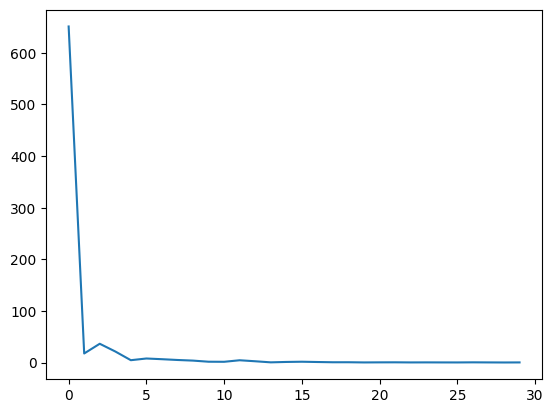

In [53]:
import matplotlib.pyplot as plt

loss = []
for i in range(30):
    loss.append(agent.learn_experience_replay(debug=False))

plt.plot(loss)
plt.show()

In [54]:
import time
import pandas as pd

def Q_learning(agent, stockfish, games_to_play, max_game_moves, board_config=None):

    loss = []
    final_score = []
    games = 0
    steps = 0
    start_time = time.time()

    # we play n games
    while games < games_to_play:

        games += 1

        # Create a new standard board
        if board_config is None:
            board = chess.Board()

        # Create a board with the desired configuration (pieces and starting positions)
        else:
            board = chess.Board(board_config)

        done = False
        game_moves = 0

        # analyse board with stockfish
        analysis = stockfish.analyse(board=board, limit=chess.engine.Limit(depth=5))

        # get best possible move according to stockfish (with depth=5)
        best_move = analysis['pv'][0]

        # until game is not finished
        while not done:

            game_moves += 1
            steps += 1

            # choose action, here the agent choose whether to explore or exploit
            action_index, move, bit_state, valid_move_tensor = agent.select_action(board, best_move)

            # save this score to compute the reward after the opponent move
            board_score_before = analysis['score'].relative.score(mate_score=10000) / 100

            # white moves
            board.push(move)

            # the game is finished (checkmate, stalemate, draw conditions, ...) or we reached max moves
            done = board.result() != '*' or game_moves > max_game_moves

            if done:

                final_result = board.result()

                # if the game is still not finished (meaning we reached max moves without ending the game) or draw
                # we assign a negative reward
                if final_result == '*' or final_result == "1/2-1/2":
                    reward = -10

                # if white wins
                elif final_result == "1-0":
                    reward = 1000

                # if black wins
                else:
                    reward = -1000

                # store sample in memory
                agent.remember(agent.MAX_PRIORITY, bit_state, action_index, reward, None, done, valid_move_tensor, None)

                board_score_after = reward

            # game not finished
            else:

                # black moves
                board.push(random.choice(list(board.legal_moves)))

                # board score is back to our perspective after black moves, so no need to change signs
                analysis = stockfish.analyse(board=board, limit=chess.engine.Limit(depth=5))
                board_score_after = analysis['score'].relative.score(mate_score=10000) / 100

                # is game finished?
                done = board.result() != '*'

                # if not done, update next best move
                if not done:
                    best_move = analysis['pv'][0]

                next_bit_state = agent.convert_state(board)
                next_valid_move_tensor, _ = agent.mask_and_valid_moves(board)

                # divide by 100 to convert from centipawns to pawns score
                reward = board_score_after - board_score_before - 0.01

                # store sample in memory
                agent.remember(agent.MAX_PRIORITY, bit_state, action_index, reward, next_bit_state, done, valid_move_tensor, next_valid_move_tensor)


            # train model and store loss
            loss.append(agent.learn_experience_replay(debug=False))

            # adjust epsilon (exploration rate)
            agent.adaptiveEGreedy()

        # save final game score
        final_score.append(board_score_after)

    # plot training results
    score_df = pd.DataFrame(final_score, columns=["score"])
    score_df['ma'] = score_df["score"].rolling(window = games // 5).mean()
    loss_df = pd.DataFrame(loss, columns=["loss"])
    loss_df['ma'] = loss_df["loss"].rolling(window=steps // 5).mean()

    # Create a figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2)

    # Plot the score chart in the first subplot
    ax1.plot(score_df.index, score_df["score"], linewidth=0.2)
    ax1.plot(score_df.index, score_df["ma"])
    ax1.set_title('Final score by game')

    # Plot the loss chart in the second subplot
    ax2.plot(loss_df.index, loss_df["loss"], linewidth=0.1)
    ax2.plot(loss_df.index, loss_df["ma"])
    ax2.set_title('Loss by training step')

    # Show the plot
    plt.show()

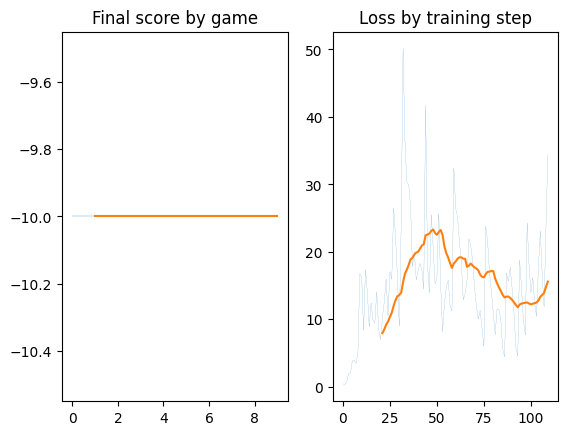

In [55]:
Q_learning(agent, stockfish, games_to_play=10, max_game_moves=10)

In [56]:
def choose_move(agent, board):

    if agent == 'random':
        chosen_move = random.choice(list(board.legal_moves))

    else:
        bit_state = agent.convert_state(board)
        valid_moves_tensor, valid_move_dict = agent.mask_and_valid_moves(board)

        with torch.no_grad():
            tensor = torch.from_numpy(bit_state).float().unsqueeze(0)
            policy_values = agent.policy_net(tensor, valid_moves_tensor)
            chosen_move_index = int(policy_values.max(1)[1].view(1, 1))

            if chosen_move_index not in valid_move_dict:
                chosen_move = random.choice(list(board.legal_moves))
            else:
                chosen_move = valid_move_dict[chosen_move_index]

    return chosen_move


def test(agent, games=1, board_config=None):

    outcomes = []
    for game in range(games):

        done = False

        # Create a new standard board
        if board_config is None:
            board = chess.Board()

        # Create a board with the desired configuration (pieces and starting positions)
        else:
            board = chess.Board(board_config)

        game_moves = 0
        while not done:
            game_moves += 1

            # white moves
            if game_moves % 2 != 0:
                board.push(choose_move(agent, board))

            # black moves
            else:
                board.push(choose_move("random", board))

            done = board.result(claim_draw=True) != '*'

        outcomes.append(board.result(claim_draw=True))

    outcome_dict = {"1-0":"White won", "1/2-1/2":"Draw", "0-1":"Black won"}
    for o in set(outcomes):
        print(f"{o} {outcome_dict[o]}: {round(outcomes.count(o)/len(outcomes)*100)}%")

In [57]:
# This is the agent we trained for just 10 games
test(agent, games=20)

1/2-1/2 Draw: 95%
0-1 Black won: 5%


In [58]:
test(ChessAgent(input_model_path="pretrained-agent-2000"), games=20)

1/2-1/2 Draw: 95%
0-1 Black won: 5%


In [59]:
mate_in_1_board = "k7/8/1K6/8/8/4R3/8/8"

board = chess.Board(mate_in_1_board)
print(board.unicode())

♚ ⭘ ⭘ ⭘ ⭘ ⭘ ⭘ ⭘
⭘ ⭘ ⭘ ⭘ ⭘ ⭘ ⭘ ⭘
⭘ ♔ ⭘ ⭘ ⭘ ⭘ ⭘ ⭘
⭘ ⭘ ⭘ ⭘ ⭘ ⭘ ⭘ ⭘
⭘ ⭘ ⭘ ⭘ ⭘ ⭘ ⭘ ⭘
⭘ ⭘ ⭘ ⭘ ♖ ⭘ ⭘ ⭘
⭘ ⭘ ⭘ ⭘ ⭘ ⭘ ⭘ ⭘
⭘ ⭘ ⭘ ⭘ ⭘ ⭘ ⭘ ⭘


In [60]:
# Create an agent
agent = ChessAgent()

# Crea una instancia del motor Stockfish
stockfish = chess.engine.SimpleEngine.popen_uci("/usr/games/stockfish")

In [61]:
# no training
test(agent, games=10, board_config=mate_in_1_board)

1/2-1/2 Draw: 100%


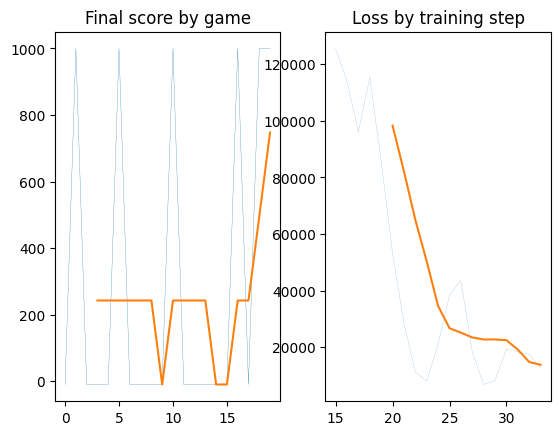

In [62]:
Q_learning(agent, stockfish, games_to_play=20, max_game_moves=1, board_config=mate_in_1_board)

In [63]:
# 20 games training
test(agent, games=10, board_config=mate_in_1_board)

1-0 White won: 100%


In [64]:
mate_in_2_board = "k7/8/8/K7/8/4R3/8/8"

board = chess.Board(mate_in_2_board)
print(board.unicode())

♚ ⭘ ⭘ ⭘ ⭘ ⭘ ⭘ ⭘
⭘ ⭘ ⭘ ⭘ ⭘ ⭘ ⭘ ⭘
⭘ ⭘ ⭘ ⭘ ⭘ ⭘ ⭘ ⭘
♔ ⭘ ⭘ ⭘ ⭘ ⭘ ⭘ ⭘
⭘ ⭘ ⭘ ⭘ ⭘ ⭘ ⭘ ⭘
⭘ ⭘ ⭘ ⭘ ♖ ⭘ ⭘ ⭘
⭘ ⭘ ⭘ ⭘ ⭘ ⭘ ⭘ ⭘
⭘ ⭘ ⭘ ⭘ ⭘ ⭘ ⭘ ⭘


In [65]:
test(agent, games=10, board_config=mate_in_2_board)

1/2-1/2 Draw: 100%


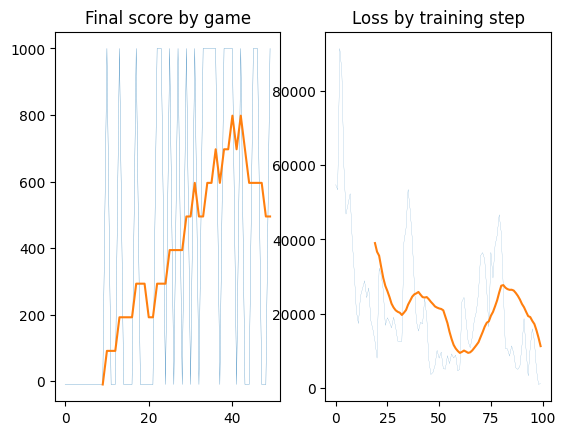

In [66]:
Q_learning(agent, stockfish, games_to_play=50, max_game_moves=1, board_config=mate_in_2_board)

In [67]:
#20 games training (mate in 1) + 50 games training (mate in 2)
test(agent, games=10, board_config=mate_in_2_board)

1-0 White won: 100%
